In [40]:
using PyCall
using LinearAlgebra
using Random
using Printf
using MLJBase

In [3]:
abstract type Node end
#@code_warntype, @simd, @inbounds, statyczne typowenie (brak niestabilności typów, brak Any), @benchmark_tools, @btime, brak alokacji, 
#kolumny czy wiersze w for
#test co szybsz, Matrix czy Array{Float64, 2}
#softmax backward

mutable struct Conv2DNode <: Node
    x::Array{Float64, 4}
    W::Array{Float64, 4}
    b::Vector{Float64}
    batch_size::Int 
    kernel_size::Tuple{Int, Int}
    filters::Int
    output::Array{Float64, 4}
    gradient_W::Array{Float64, 4}
    gradient_b::Vector{Float64}
    activation::String
    m_W::Array{Float64}
    v_W::Array{Float64}
    m_b::Array{Float64}
    v_b::Array{Float64}
end

mutable struct MaxPoolNode <: Node
    x::Array{Float64, 4}
    pool_size::Tuple{Int, Int}
    output::Array{Float64, 4}
end

mutable struct DenseNode <: Node
    x::Matrix{Float64}
    W::Matrix{Float64} 
    b::Vector{Float64}
    neurons::Int
    output::Matrix{Float64}
    gradient_W::Matrix{Float64}
    gradient_b::Matrix{Float64}
    activation::String
    m_W::Array{Float64}
    v_W::Array{Float64}
    m_b::Array{Float64}
    v_b::Array{Float64}
end

mutable struct FlattenNode <: Node
    x::Array{Float64, 4}
    output::Matrix{Float64}
    input_shape::Tuple{Int, Int, Int}
end

mutable struct ReLUNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
end

mutable struct SoftmaxNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
    loss_func::Union{Function, Nothing}
end

mutable struct SigmoidNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
    loss_func::Union{Function, Nothing}
end

mutable struct TanhNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
end

mutable struct LeakyReLUNode <: Node
    x::Union{Array{Float64, 4}, Matrix{Float64}}
    output::Union{Array{Float64, 4}, Matrix{Float64}}
    alpha::Float64
end


In [4]:
function forward!(node::Conv2DNode, x::Array{Float64, 4}) 
    @views node.x = x
    W = node.W
    b = node.b

    batch_size, input_height, input_width, input_channels = size(x)
    filter_height, filter_width,  num_chanels, num_filters = size(W)

    output_height = 1 + (input_height - filter_height)
    output_width = 1 + (input_width - filter_width)

    output = zeros(batch_size, output_height, output_width, num_filters)
    @simd for n in 1:batch_size
        for f in 1:num_filters
            for j in 1:output_width, i in 1:output_height
                @inbounds output[n, i, j, f] = sum(view(x, n, i:i+filter_height-1, j:j+filter_width-1, :) .* W[:,:,:,f]) + b[f]
            end
        end
    end
    
    @views node.output = output
end

function forward!(node::MaxPoolNode, x::Array{Float64, 4})
    @views node.x = x
    pool_size = node.pool_size
    
    batch_size, input_height, input_width, input_channels = size(x)

    output_height = 1 + (input_height - pool_size[1]) ÷ pool_size[1]
    output_width = 1 + (input_width - pool_size[2]) ÷ pool_size[2]

    output = zeros(batch_size, output_height, output_width, input_channels)

    @simd for n in 1:batch_size
        for c in 1:input_channels
            @inbounds for j in 1:pool_size[2]:input_width-pool_size[2]+1, i in 1:pool_size[1]:input_height-pool_size[1]+1
                @inbounds output[n, 1+div(i-1, pool_size[1]), 1+div(j-1, pool_size[2]), c] = maximum(view(x, n, i:i+pool_size[1]-1, j:j+pool_size[2]-1, c))
            end
        end
    end

    @views node.output = output
end

function forward!(node::FlattenNode, x::Array{Float64, 4})
    node.x = x
    node.output = reshape(x, size(x, 1), size(x, 2) * size(x, 3) * size(x, 4))
end

function forward!(node::DenseNode, x::Matrix{Float64})
    node.x = x
    @views node.output = x * node.W .+ node.b'
end

function forward!(node::ReLUNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    @views node.output = max.(0, x)
end

function forward!(node::SoftmaxNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    exp_x = exp.(x .- maximum(x, dims=2))
    node.output = exp_x ./ sum(exp_x, dims=2)
end

function forward!(node::SigmoidNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    node.output = 1.0 ./ (1.0 .+ exp.(-x))
end

function forward!(node::TanhNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    node.output = tanh.(x)
end

function forward!(node::LeakyReLUNode, x::Union{Array{Float64, 4}, Matrix{Float64}})
    node.x = x
    @views node.output = ifelse.(x .> 0, x, node.alpha .* x)
end

forward! (generic function with 9 methods)

In [5]:
function backward!(node::Conv2DNode, dy::Array{Float64, 4}, x::Array{Float64, 4})
    W = node.W
    batch_size, input_height, input_width, input_channels = size(x)
    filter_height, filter_width, num_channels, num_filters = size(W)

    dx = zeros(size(x))
    dW = zeros(size(W))
    db = zeros(num_filters)

    @simd for n in 1:batch_size
        for f in 1:num_filters
            for j in 1:input_width - filter_width + 1, i in 1:input_height - filter_height + 1
                @inbounds dx[n, i:i + filter_height - 1, j:j + filter_width - 1, :] .+= W[:, :, :, f] .* dy[n, i, j, f]
                @inbounds dW[:, :, :, f] .+= view(x, n, i:i + filter_height - 1, j:j + filter_width - 1, :) .* dy[n, i, j, f]
            end
            @inbounds db[f] += sum(dy[n, :, :, f])
        end
    end

    return (dx, dW, db)
end


function backward!(node::MaxPoolNode, dy::Array{Float64, 4}, x::Array{Float64, 4})
    pool_size = node.pool_size
    new_size = size(node.output)
    dy = reshape(dy, new_size)
    
    batch_size, height, width, channels = size(x)
    dx = zeros(size(x))
    @simd for b in 1:batch_size
        for c in 1:channels
            @inbounds for j in 1:pool_size[2]:width-pool_size[2]+1, i in 1:pool_size[1]:height-pool_size[1]+1
                @inbounds window = view(x, b, i:i+pool_size[1]-1, j:j+pool_size[2]-1, c)
                @inbounds dx[b, i:i+pool_size[1]-1, j:j+pool_size[2]-1, c] .+= dy[b, i ÷ pool_size[1]+1, j ÷ pool_size[2]+1, c] .* (window .== maximum(window))
            end
        end
    end
    return dx
end


function backward!(node::DenseNode, dy::Matrix{Float64}, x::Matrix{Float64})
    dx, dW, db = dy * node.W', x' * dy, reshape(sum(dy, dims=1), :, 1)
    return (dx, dW, db)
end

function backward!(node::FlattenNode, dy::Matrix{Float64}, x::Array{Float64, 4})
    dx = reshape(dy, size(x, 1), node.input_shape...)
    return dx
end


function backward!(node::ReLUNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    dx = dy .* (x .> 0)
    return dx
end

function backward!(node::SigmoidNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    dx = dy .* (node.output .* (1.0 .- node.output))
    return dx
end

function backward!(node::TanhNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    dx = dy .* (1.0 .- node.output .^ 2)
    return dx
end

function backward!(node::LeakyReLUNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    dx = dy .* ifelse.(x .> 0, 1, node.alpha)
    return dx
end

function backward!(node::SoftmaxNode, dy::Union{Array{Float64, 4}, Matrix{Float64}}, x::Union{Array{Float64, 4}, Matrix{Float64}})
    softmax_output = node.output
    batch_size, num_classes = size(softmax_output)

    dx = similar(dy)

    @simd for i in 1:batch_size
        vec = view(softmax_output, i, :)
        J = diagm(vec) .- vec * vec'
        view(dx, i, :) .= J' * view(dy, i, :)
    end

    return dx
end


backward! (generic function with 9 methods)

In [6]:
function Conv2DNode(; batch_size::Int, filters::Int, kernel_size::Tuple{Int, Int}, input_shape::Tuple{Int, Int, Int}, activation::String)
    W = randn(kernel_size[1], kernel_size[2], input_shape[3], filters) * sqrt(1 / (kernel_size[1] * kernel_size[2] * input_shape[3]))
    b = zeros(filters)

    return Conv2DNode(zeros(1,1,1,1), W, b, batch_size, kernel_size, filters, zeros(1,1,1,1), zeros(1, 1, 1, 1), zeros(1), activation, zeros(size(W)), zeros(size(W)), zeros(size(b)), zeros(size(b)))
end

function MaxPoolNode(; pool_size::Tuple{Int, Int})
    return MaxPoolNode(zeros((1, 1, 1, 1)), pool_size, zeros((1, 1, 1, 1)))
end

function DenseNode(; neurons::Int, activation::String, input_shape::Union{Tuple{Int, Int}, Tuple{Int, Int, Int}})
    W = randn(prod(input_shape), neurons) * sqrt(1 / (prod(input_shape)))
    b = zeros(neurons)

    return DenseNode(zeros(1,1), W, b, neurons, zeros((1,1)), zeros((1, 1)), zeros((1, 1)), activation, zeros(size(W)), zeros(size(W)), zeros(size(b)), zeros(size(b)))
end

function FlattenNode(; input_shape::Tuple{Int, Int, Int})
    return FlattenNode(zeros((input_shape..., 1)), zeros((1, 1)), input_shape)
end

function ReLUNode()
    return ReLUNode(zeros((1, 1, 1, 1)), zeros((1, 1, 1, 1)))
end

function SoftmaxNode()
    return SoftmaxNode(zeros((1, 1)), zeros((1, 1)), nothing)
end

function TanhNode()
    return TanhNode(zeros((1, 1)), zeros((1, 1)))
end

function SigmoidNode()
    return SigmoidNode(zeros((1, 1)), zeros((1, 1)), nothing)
end

function LeakyReLUNode(alpha::Float64)
    return LeakyReLUNode(zeros((1, 1)), zeros((1, 1)), alpha)
end

function forward_pass!(graph::Vector{Any}, x::Array{Float64, 4})
    input = x
    for node in graph
        @inbounds forward!(node, input)
        input = @views node.output
    end
    return input
end

function backward_pass!(graph::Vector{Any}, y_true::Vector{Int64})
    preds = graph[end].output
    dout  = graph[end].loss_func(preds, y_true) #loss func backpropagation

    for i in reverse(1:length(graph))
        layer = graph[i]
        prev_layer_output = i > 1 ? graph[i - 1].output : layer.x
        if hasproperty(layer, :gradient_W)
            @inbounds dout,dW,db = backward!(layer, dout, prev_layer_output)
            layer.gradient_W = dW
            layer.gradient_b = db

        else 
            @inbounds dout = backward!(layer, dout, prev_layer_output)
        end
    end
end

function onehotbatch(labels::Vector{Int64}, classes::UnitRange{Int64})
    Y = zeros(Int, length(labels), length(classes))
    for (i, label) in enumerate(labels)
        Y[i, label .== classes] .= 1
    end
    return Y
end

function graph_build(layers::Vector{Node}, loss::String)
    output = []
    for layer in layers
        push!(output, layer)
        if hasproperty(layer, :activation)
            push!(output, getActivation(layer.activation))
        end
    end
    
    if loss == "cross_entropy_loss"
        output[end].loss_func = cross_entropy_backward
    else
        error("Invalid activation function for output layer")
    end
    
    return output
end

function getActivation(name::String)
    if name == "relu"
        return ReLUNode()
    elseif name == "softmax"
        return SoftmaxNode()
    elseif name == "sigmoid"
        return SigmoidNode()
    elseif name == "tanh"
        return TanhNode()
    elseif name == "leakyrelu"
        return LeakyReLUNode(0.01)
    else 
        error("no such activation function")
    end
end

function cross_entropy_backward(y_pred::Matrix{Float64}, y_true::Vector{Int64})
    return -(onehotbatch(y_true, 0:9) ./ y_pred) ./ size(y_true, 1)
end

import Base.hasproperty
hasproperty(x, s::Symbol) = s in fieldnames(typeof(x))

hasproperty (generic function with 1 method)

In [106]:
function update_adam!(layer::Node, learning_rate::Float64, t::Int, beta1::Float64 = 0.9, beta2::Float64 = 0.999, epsilon::Float64 = 1e-8)
    layer.m_W = beta1 * layer.m_W + (1 - beta1) * layer.gradient_W
    layer.v_W = beta2 * layer.v_W + (1 - beta2) * layer.gradient_W .^ 2
    mhat_W = layer.m_W / (1 - beta1 ^ t)
    vhat_W = layer.v_W / (1 - beta2 ^ t)
    layer.W .-= learning_rate .* mhat_W ./ (sqrt.(vhat_W) .+ epsilon)


    layer.m_b = beta1 * layer.m_b + (1 - beta1) * layer.gradient_b
    layer.v_b = beta2 * layer.v_b + (1 - beta2) * layer.gradient_b .^ 2
    mhat_b = layer.m_b / (1 - beta1 ^ t)
    vhat_b = layer.v_b / (1 - beta2 ^ t)
    layer.b .-= learning_rate .* mhat_b ./ (sqrt.(vhat_b) .+ epsilon)
end

function update_sgd!(layer::Node, learning_rate::Float64)
    layer.W .-= learning_rate .* layer.gradient_W
    layer.b .-= learning_rate .* layer.gradient_b
end

function train!(graph::Vector{Any}, train_x::Array{Float64, 4}, train_y::Vector{Int64}, epochs::Int=5, batch_size::Int=32, learning_rate::Float64=1e-3, optimizer::String="adam")
    total_batches = ceil(Int, size(train_x, 1) / batch_size)
    each = ceil(Int, total_batches/10)
 
    loss_history = zeros(ceil(Int, total_batches*epochs/each))
    counter = 1
    
    for epoch in 1:epochs
        println("----EPOCH $epoch----")

        idx = randperm(size(train_x, 1))
        train_x = train_x[idx, :, :, :]
        train_y = train_y[idx]
        loss = 0
        current_epoch_loss = zeros(total_batches)
        

        for i in 1:batch_size:size(train_x, 1)
            x_batch = train_x[i:min(i+batch_size-1, end), :, :, :]
            y_batch = train_y[i:min(i+batch_size-1, end)]
            tmp  = (i ÷ batch_size)

            forward_pass!(graph, x_batch)
            
            current_epoch_loss[tmp+1] = -sum(log.(graph[end].output) .* onehotbatch(y_batch, 0:9))#/size(y_batch, 1)
            
            backward_pass!(graph, y_batch)

            for layer in graph
                if hasproperty(layer, :gradient_W)
                    if optimizer == "adam"
                        update_adam!(layer, learning_rate, i)
                    elseif optimizer == "sgd"
                        update_sgd!(layer, learning_rate)
                    else
                        error("Invalid optimizer selected.")
                    end
                end
            end

            
            if i == 1  ||  tmp % each == 0
                avg_loss = sum(current_epoch_loss)/(tmp+1)

                loss_history[counter] = avg_loss
                counter += 1
                print(i ÷ batch_size, "/", total_batches)
                println(" avg epoch loss: ", round(avg_loss, digits=5))
                
            end
        end
        println()
        
    end
    println("Training finished!")

    return loss_history
end

function evaluate(graph::Vector{Any}, x_data::Array{Float64, 4}, y_data::Vector{Int64}, batch_size::Int, pool_size::Tuple{Int, Int})
    num_correct = 0
    num_samples = size(x_data, 1)

    for i in 1:batch_size:num_samples
        x_batch = x_data[i:min(i+batch_size-1, end), :, :, :]
        y_batch = y_data[i:min(i+batch_size-1, end)]
        
        forward_pass!(graph, x_batch)
        pred = graph[end].output
        
        predictions = argmax.(eachrow(pred)) .- 1
        num_correct += sum(predictions .== y_batch)
    end

    accuracy = num_correct / num_samples
    return accuracy
end

function plot_loss(loss::Vector{Float64}, epochs::Int)
    plot(1:size(loss,1), loss, label="loss_batches")

    each = Int64(size(loss,1)/epochs)
    pts = loss[each:each:end]
    plot!(each:each:each*size(pts,1), pts, seriestype=:scatter, label="epochs")
end

function classification_report(y_true::Array{Int}, y_pred::Array{Int})
    labels = sort(unique(y_true))
    num_classes = length(labels)
    tp = zeros(Int, num_classes)
    fp = zeros(Int, num_classes)
    fn = zeros(Int, num_classes)

    for i in 1:num_classes
        tp[i] = sum((y_true .== labels[i]) .& (y_pred .== labels[i]))
        fp[i] = sum((y_true .!= labels[i]) .& (y_pred .== labels[i]))
        fn[i] = sum((y_true .== labels[i]) .& (y_pred .!= labels[i]))
    end

    precision = tp ./ (tp .+ fp)
    recall = tp ./ (tp .+ fn)
    f1_score = 2 * (precision .* recall) ./ (precision .+ recall)
    support = tp .+ fn
    total_support = sum(support)
    weighted_precision = sum(precision .* support) / total_support
    weighted_recall = sum(recall .* support) / total_support
    weighted_f1_score = sum(f1_score .* support) / total_support

    println("Class \t\t Precision \t Recall \t F1-score \t Support")
    for i in 1:num_classes
        @printf("%-10d \t %-10.4f \t %-10.4f \t %-10.4f \t %d \n", labels[i], precision[i], recall[i], f1_score[i], support[i])
    end

    println("------------------------------------------------")
    @printf("Avg/Total \t %-10.4f \t %-10.4f \t %-10.4f \t %d\n", weighted_precision, weighted_recall, weighted_f1_score, total_support)


end

function plot_confusion_matrix(y_true::Array{Int}, y_pred::Array{Int})
    cm = Matrix(MLJBase.confusion_matrix(y_true, y_pred).mat)
    heatmap(cm, c = :Reds_8, title="Confusion Matrix", size=(700, 700))

    for i in 1:size(cm, 1)
        for j in 1:size(cm, 2)
            annotate!([(i, j, Plots.text(string(cm[j, i]), 10, :black, :center))])
        end
    end

    xlabel!("Predicted")
    ylabel!("Actual")
end

function predict(graph::Vector{Any}, x::Array{Float64, 4}, batch_size::Int)
    num_samples = size(x, 1)
    num_batches = ceil(Int, num_samples / batch_size)

    class_labels = zeros(Int, num_samples)

    for i in 1:batch_size:num_samples
        x_batch = x[i:min(i + batch_size - 1, end), :, :, :]
        preds = forward_pass!(graph, x_batch)
        max_indices = argmax.(eachrow(preds)) .- 1
        class_labels[i:min(i + batch_size - 1, end)] = vec(max_indices)
    end

    return class_labels
end


predict (generic function with 2 methods)

In [9]:
mnist = pyimport("mnist")

# Load the MNIST dataset
train_data = mnist.train_images()
train_labels = Int64.(mnist.train_labels())
train_x =  reshape(train_data, :, 28, 28, 1) / 255.0
train_y = train_labels


n = 1000
idx = randperm(n)
train_x = train_x[idx, :,:,:]
train_y = train_y[idx]

train_y[1]

9

----EPOCH 1----


0/16 avg epoch loss: 

150.44708
2/16 avg epoch loss: 142.09055


4/16 avg epoch loss: 134.74765


6/16 avg epoch loss: 130.33736


8/16 avg epoch loss: 117.46699


10/16 avg epoch loss: 107.34926


12/16 avg epoch loss: 101.98348


14/

16 avg epoch loss: 94.80535

----EPOCH 2----


0/16 avg epoch loss: 23.50798


2/16 avg epoch loss: 32.78016


4/16 avg epoch loss: 28.37525


6/16 avg epoch loss: 26.93751


8/16 avg epoch loss: 27.38824


10/16 avg epoch loss: 29.05519


12/16 avg epoch loss: 27.29495


14/16 avg epoch loss: 26.87169



----EPOCH 3----


0/16 avg epoch loss: 15.89294


2/16 avg epoch loss: 13.20585


4/16 avg epoch loss: 12.33677


6/16 avg epoch loss: 10.74021


8/16 avg epoch loss: 11.70033


10/16 avg epoch loss: 11.33419


12/16 avg epoch loss: 11.99929


14/16 avg epoch loss: 12.43663



----EPOCH 4----


0/16 avg epoch loss: 6.58728


2/16 avg epoch loss: 7.27604


4/16 avg epoch loss: 8.14829


6/16 avg epoch loss: 8.76758


8/16 avg epoch loss: 8.0939


10/16 avg epoch loss: 7.66221


12/16 avg epoch loss: 7.44609


14/16 avg epoch loss: 6.88822



----EPOCH 5----


0/16 avg epoch loss: 3.02987


2/16 avg epoch loss: 3.85873


4/16 avg epoch loss: 7.65593


6/16 avg epoch loss: 6.6696


8/16 avg epoch loss: 5.49595


10/16 avg epoch loss: 5.42251


12/16 avg epoch loss: 4.8236


14/16 avg epoch loss: 4.60791



----EPOCH 6----


0/16 avg epoch loss: 0.77424


2/16 avg epoch loss: 1.39532


4/16 avg epoch loss: 1.38187


6/16 avg epoch loss: 1.9195


8/16 avg epoch loss: 2.1314


10/16 avg epoch loss: 1.8848


12/16 avg epoch loss: 2.17244


14/16 avg epoch loss: 2.56861



----EPOCH 7----


0/16 avg epoch loss: 0.58365


2/16 avg epoch loss: 1.03994


4/16 avg epoch loss: 1.47329


6/16 avg epoch loss: 

1.44244
8/16 avg epoch loss: 1.37242


10/16 avg epoch loss: 1.544


12/16 avg epoch loss: 1.47435


14/16 avg epoch loss: 1.62443



----EPOCH 8----


0/16 avg epoch loss: 1.14607


2/16 avg epoch loss: 1.07525


4/16 avg epoch loss: 1.38567


6/16 avg epoch loss: 1.22054


8/16 avg epoch loss: 1.06426


10/16 avg epoch loss: 1.02864


12/16 avg epoch loss: 0.99885


14/16 avg epoch loss: 0.93916



----EPOCH 9----


0/16 avg epoch loss: 0.36588


2/16 avg epoch loss: 0.95052


4/16 avg epoch loss: 0.73089


6/16 avg epoch loss: 

0.69293
8/16 avg epoch loss: 0.75291


10/16 avg epoch loss: 0.67894


12/16 avg epoch loss: 0.86473


14/16 avg epoch loss: 0.83403



----EPOCH 10----


0/16 avg epoch loss: 0.41806


2/16 avg epoch loss: 0.54152


4/16 avg epoch loss: 0.4338


6/16 avg epoch loss: 0.4626


8/16 avg epoch loss: 0.55661


10/16 avg epoch loss: 0.55137


12/16 avg epoch loss: 0.48408


14/16 avg epoch loss: 0.46503



Training finished!

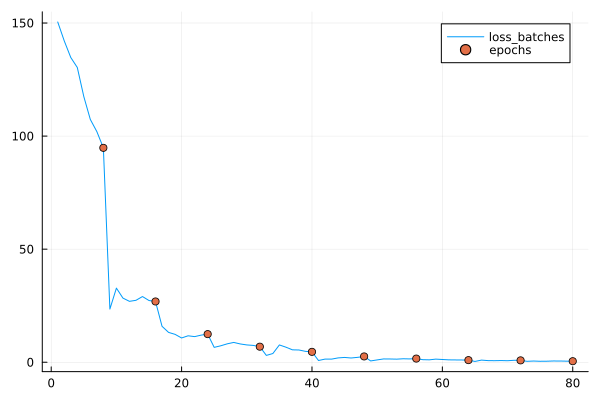

In [10]:
using Plots
using BenchmarkTools: @btime
using ProfileSVG

epochs = 10
batch_size = 64
learning_rate = 0.0075
pool_size = (4,4)

model = [
    Conv2DNode(batch_size=batch_size, filters=24, kernel_size=(3,3), input_shape=(28,28,1), activation="relu"),
    MaxPoolNode(pool_size=(4,4)),
    FlattenNode(input_shape=(6,6,24)),
    DenseNode(neurons=32, activation="relu", input_shape=(prod((6,6,24)), 1)),
    DenseNode(neurons=10, activation="softmax", input_shape=(32,1))
]

graph = graph_build(model, "cross_entropy_loss")

loss = train!(graph, train_x, train_y, epochs, batch_size, learning_rate, "adam")
plot_loss(loss, epochs)

In [11]:
test_data = mnist.test_images()
test_labels = Int64.(mnist.test_labels())

test_x =  reshape(test_data, :, 28, 28, 1) / 255.0
test_y = test_labels

n = 5000
idx = randperm(n)

test_x = test_x[idx, :,:,:]
test_y = test_y[idx]

accuracy = evaluate(graph, test_x, test_y, batch_size, pool_size)
println("Accuracy: ", accuracy)

Accuracy: 0.9068


Class 		 Precision 	 Recall 	 F1-score 	 Support
0          	 0.9461     	 0.9543     	 0.9502     	 460 
1          	 0.9772     	 0.9772     	 0.9772     	 571 
2          	 0.8891     	 0.9075     	 0.8982     	 530 
3          	 0.9050     	 0.8760     	 0.8902     	 500 
4          	 0.9476     	 0.9040     	 0.9253     	 500 
5          	 0.8991     	 0.8794     	 0.8891     	 456 
6          	 0.9247     	 0.9307     	 0.9277     	 462 
7          	 0.9256     	 0.8750     	 0.8996     	 512 
8          	 0.8742     	 0.7955     	 0.8330     	 489 
9          	 0.7994     	 0.9577     	 0.8714     	 520 
------------------------------------------------
Avg/Total 	 0.9090     	 0.9068     	 0.9068     	 5000


┌ Warning: The classes are un-ordered,
│ using order: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase C:\Users\anczo\.julia\packages\MLJBase\g5E7V\src\measures\confusion_matrix.jl:122


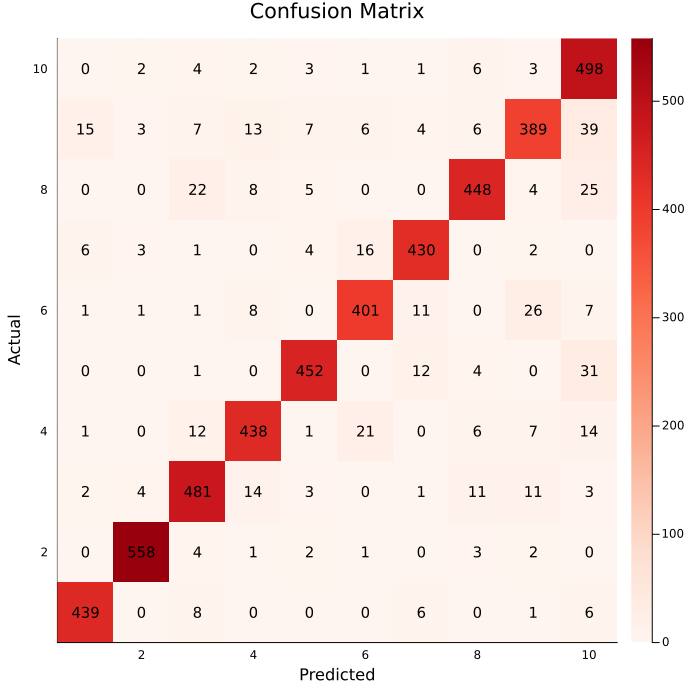

In [107]:
pred_y = predict(graph, test_x, batch_size)
classification_report(test_y, pred_y)
plot_confusion_matrix(test_y, pred_y)

----EPOCH 1----


0/938 avg epoch loss: 153.89149


94/938 avg epoch loss: 135.0295


188/938 avg epoch loss: 120.15896


282/938 avg epoch loss: 105.91018


376

/938 avg epoch loss: 94.38652
470/938 avg epoch loss: 84.90334


564/938 avg epoch loss: 77.36919


658/938 avg epoch loss: 71.45464


752/938 avg epoch loss: 66.77687


846/938 avg epoch loss: 

62.70663

----EPOCH 2----


0/938 avg epoch loss: 28.44691


94/938 avg epoch loss: 26.93317


188/938 avg epoch loss: 25.79848


282/938 avg epoch loss: 24.89389


376/938 avg epoch loss: 24.3815


470/938 avg epoch loss: 23.7726


564/938 avg epoch loss: 23.51689


658/938 avg epoch loss: 23.07665


752/938 avg epoch loss: 22.63488


846/938 avg epoch loss: 22.285



----EPOCH 3----


0/938 avg epoch loss: 22.37159


94/

938 avg epoch loss: 19.09239
188/938 avg epoch loss: 18.71828


282/938 avg epoch loss: 18.14781


376/938 avg epoch loss: 17.94659


470/938 avg epoch loss: 17.77953


564/938 avg epoch loss: 17.7308


658/938 avg epoch loss: 17.32898


752/938 avg epoch loss: 17.03266


846/938 avg epoch loss: 16.75234

----EPOCH 4----


0/938 avg epoch loss: 17.39868


94/938 avg epoch loss: 14.7854


188/938 avg epoch loss: 15.0993


282/938 avg epoch loss: 14.82323


376

/938 avg epoch loss: 14.54911
470/938 avg epoch loss: 14.38062


564/938 avg epoch loss: 14.15572


658/938 avg epoch loss: 14.10847


752/938 avg epoch loss: 13.91001


846/938 avg epoch loss: 13.82006



----EPOCH 5----


0/938 avg epoch loss: 6.76944


94/938 avg epoch loss: 12.81709


188/938 avg epoch loss: 12.86324


282/938 avg epoch loss: 12.58277


376/938 avg epoch loss: 12.43814


470/938 avg epoch loss: 

12.2788
564/938 avg epoch loss: 12.21613


658/938 avg epoch loss: 12.1031


752/938 avg epoch loss: 12.01576


846/938 avg epoch loss: 11.90365



----EPOCH 6----


0/938 avg epoch loss: 10.4255


94/938 avg epoch loss: 11.67899


188/938 avg epoch loss: 11.32726


282/938 avg epoch loss: 11.12233


376/938

 avg epoch loss: 10.99609
470/938 avg epoch loss: 10.84434


564/938 avg epoch loss: 10.65465


658/938 avg epoch loss: 10.50085


752/938 avg epoch loss: 10.42065


846/938 avg epoch loss: 10.45865



----EPOCH 7----


0/938 avg epoch loss: 6.89326


94/938 avg epoch loss: 9.73394


188/938 avg epoch loss: 9.44549


282

/938 avg epoch loss: 9.62092
376/938 avg epoch loss: 9.58225


470/938 avg epoch loss: 9.64317


564/938 avg epoch loss: 

9.68792
658/938 avg epoch loss: 9.55251


752/938 avg epoch loss: 

9.38389
846/938 avg epoch loss: 9.31726



----EPOCH 8----


0/938 avg epoch loss: 8.43487


94/938 avg epoch loss: 8.56707


188/938 avg epoch loss: 8.99803


282/938 avg epoch loss: 8.66426


376/938 avg epoch loss: 8.72433


470/938 avg epoch loss: 8.66901


564/938 avg epoch loss: 8.69732


658/938 avg epoch loss: 8.61137


752/938 avg epoch loss: 8.58562


846/938 avg epoch loss: 8.53367



----EPOCH 9----


0/938 avg epoch loss: 7.59495


94/938 avg epoch loss: 8.34428


188/938 avg epoch loss: 8.29197


282/938 avg epoch loss: 

7.9186
376/938 avg epoch loss: 7.91981


470/938 avg epoch loss: 7.91511


564/938 avg epoch loss: 7.97781


658/938 avg epoch loss: 7.93265


752/938 avg epoch loss: 7.81754


846/938 avg epoch loss: 7.88155



----EPOCH 10----


0/938 avg epoch loss: 9.64987


94/938

 avg epoch loss: 7.06679
188/938 avg epoch loss: 7.30477


282/938 avg epoch loss: 7.30029


376/938 avg epoch loss: 7.49646


470/938 avg epoch loss: 7.40346


564/938 avg epoch loss: 7.355


658/938 avg epoch loss: 7.33632


752/938 avg epoch loss: 7.33419


846/938 avg epoch loss: 7.29986



Training finished!


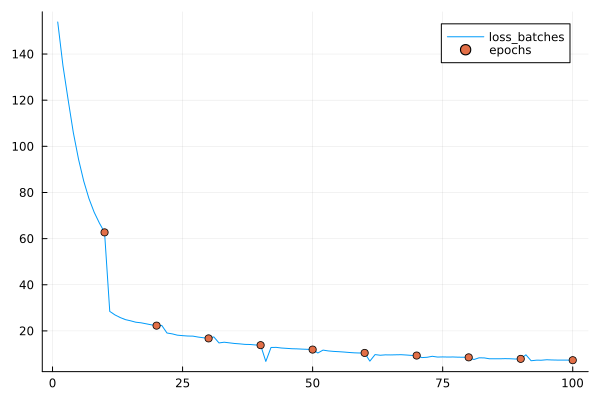

In [12]:
epochs = 10
batch_size = 64
learning_rate = 0.0075
pool_size = (4,4)

model = [
    Conv2DNode(batch_size=batch_size, filters=24, kernel_size=(3,3), input_shape=(28,28,1), activation="relu"),
    MaxPoolNode(pool_size=(4,4)),
    FlattenNode(input_shape=(6,6,24)),
    DenseNode(neurons=32, activation="relu", input_shape=(prod((6,6,24)), 1)),
    DenseNode(neurons=10, activation="softmax", input_shape=(32,1))
]

graph1 = graph_build(model, "cross_entropy_loss")

loss1 = train!(graph1, train_x, train_y, epochs, batch_size, learning_rate, "sgd")
plot_loss(loss1, epochs)

In [13]:
accuracy = evaluate(graph1, test_x, test_y, batch_size, pool_size)
println("Accuracy: ", accuracy)

Accuracy: 0.9594


In [59]:
pred_y = predict(graph1, test_x, batch_size)
classification_report(test_y, pred_y)
plot_confusion_matrix(test_y, pred_y)